## Setup

In [24]:
import os
import sys
import random

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import numpy as np

sys.path.append("../src")

import models  # noqa: E402
import utils  # noqa: E402
import train.backprop  # noqa: E402
import train.ff  # noqa: E402
import train.pc  # noqa: E402

os.makedirs("../results", exist_ok=True)

In [25]:
# Config

batch_size = 32
n_classes = 10
lr = 0.001
n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [26]:
# Load data

train_loader, val_loader, test_loader = utils.load_mnist_data(batch_size)
class_names = [str(i) for i in range(n_classes)]

## Backprop

In [ ]:
import importlib

importlib.reload(train.backprop)

# Initialize model, loss, optimizer
model = models.LeNet5(n_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

n_params = sum(p.numel() for p in model.parameters())
torchinfo.summary(model, input_size=(batch_size, 1, 32, 32))
print("")

# Train model using backpropagation
history = train.backprop.backprop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)

# Save trained model
save_path = "../results/backprop-model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\nTraining completed. Model saved to '{save_path}'")

# Save training history
dst = "../results/backprop-history.csv"
pd.DataFrame(history).to_csv(dst, index=False)

# Evaluate model
test_metrics = train.backprop.evaluate(model, test_loader, criterion, device)
utils.save_metrics(test_metrics, "../results/mnist-metrics.csv", "backprop")

# Final summary
print("\nBackpropagation – Training Summary")
print("-" * 60)
print(f"Train accuracy: {history['train_accuracies'][-1]:.2f}")
print(f"Val accuracy: {history['val_accuracies'][-1]:.2f}")
print(f"Test accuracy: {test_metrics['accuracy']:.2f}")
print(f"Params: {n_params:,}")
print(f"Epochs: {n_epochs}")


Starting backpropagation training
------------------------------------------------------------
Epoch: [1/10]  Train Loss: 0.1423,  Train Acc:   0.96,  Val Loss: 0.0863,  Val Acc:   0.98,  Time:  9.88s
Epoch: [2/10]  Train Loss: 0.0558,  Train Acc:   0.98,  Val Loss: 0.0549,  Val Acc:   0.98,  Time:  9.48s
Epoch: [3/10]  Train Loss: 0.0420,  Train Acc:   0.99,  Val Loss: 0.0572,  Val Acc:   0.98,  Time:  9.51s
Epoch: [4/10]  Train Loss: 0.0340,  Train Acc:   0.99,  Val Loss: 0.0437,  Val Acc:   0.99,  Time:  9.43s
Epoch: [5/10]  Train Loss: 0.0260,  Train Acc:   0.99,  Val Loss: 0.0501,  Val Acc:   0.99,  Time:  9.50s
Epoch: [6/10]  Train Loss: 0.0229,  Train Acc:   0.99,  Val Loss: 0.0427,  Val Acc:   0.99,  Time:  9.51s
Epoch: [7/10]  Train Loss: 0.0189,  Train Acc:   0.99,  Val Loss: 0.0475,  Val Acc:   0.99,  Time:  9.49s
Epoch: [8/10]  Train Loss: 0.0172,  Train Acc:   0.99,  Val Loss: 0.0489,  Val Acc:   0.99,  Time:  9.56s
Epoch: [9/10]  Train Loss: 0.0154,  Train Acc:   1.00,  

## Forward-forward

In [ ]:
import importlib

importlib.reload(train.ff)

# Initialize model, loss, optimizer
model = models.FFLeNet5(n_classes=n_classes)
optimizers = [torch.optim.Adam(layer.parameters(), lr=lr) for layer in model.layers]

n_params = sum(p.numel() for p in model.parameters())
torchinfo.summary(model, input_size=(batch_size, 1 + n_classes, 32, 32))
print("")

# Train model using forward-forward
# - No criterion: FF does not use global loss
# - No optimizer: FF uses per-layer optimizers
history = train.ff.forward_forward(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizers=optimizers,
    n_epochs=n_epochs,
    device=device,
    n_classes=n_classes,
    threshold=2.0,
)

# Save trained model
save_path = "../results/ff-model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\nTraining completed. Model saved to '{save_path}'")

# Save training history
dst = "../results/ff-history.csv"
pd.DataFrame(history).to_csv(dst, index=False)

# Evaluate model
test_metrics = train.ff.evaluate(model, test_loader, n_classes, device)
utils.save_metrics(test_metrics, "../results/mnist-metrics.csv", "ff")

# Final summary
print("\nForward-Forward – Training Summary")
print("-" * 60)
if history["train_accuracies"][-1] is not None:
    print(f"Train accuracy: {history['train_accuracies'][-1]:.2f}")
print(f"Val accuracy: {history['val_accuracies'][-1]:.2f}")
print(f"Test accuracy: {test_metrics['accuracy']:.2f}")
print(f"Params: {n_params:,}")
print(f"Epochs: {n_epochs}")


Starting forward-forward training
------------------------------------------------------------
Epoch: [1/10]  Train Loss: 9.9996,  Train Acc:   0.52%,  Val Acc:   0.84,  Time: 91.54s
Epoch: [2/10]  Train Loss: 2.8268,  Train Acc:   0.86%,  Val Acc:   0.88,  Time: 92.90s
Epoch: [3/10]  Train Loss: 2.2736,  Train Acc:   0.90%,  Val Acc:   0.92,  Time: 102.73s
Epoch: [4/10]  Train Loss: 1.8542,  Train Acc:   0.92%,  Val Acc:   0.92,  Time: 97.96s
Epoch: [5/10]  Train Loss: 1.7300,  Train Acc:   0.93%,  Val Acc:   0.94,  Time: 99.53s
Epoch: [6/10]  Train Loss: 1.5402,  Train Acc:   0.94%,  Val Acc:   0.93,  Time: 105.07s
Epoch: [7/10]  Train Loss: 1.4210,  Train Acc:   0.94%,  Val Acc:   0.87,  Time: 104.43s
Epoch: [8/10]  Train Loss: 1.3497,  Train Acc:   0.94%,  Val Acc:   0.93,  Time: 106.96s
Epoch: [9/10]  Train Loss: 1.3605,  Train Acc:   0.94%,  Val Acc:   0.93,  Time: 105.14s
Epoch: [10/10]  Train Loss: 1.2418,  Train Acc:   0.95%,  Val Acc:   0.95,  Time: 107.12s

Training complet

## Predictive Coding

In [ ]:
import importlib

importlib.reload(train.pc)

# Hyperparameters
N_INFERENCE_STEPS = 5
INFERENCE_LEARNING_RATE = 5e-5


def create_model(latent_dim=84, n_classes=n_classes):
    """Creates a fresh instance of the CNN architecture."""
    return nn.Sequential(
        nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2)),
        nn.Sequential(nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2)),
        nn.Sequential(nn.Flatten(), nn.Linear(16 * 5 * 5, 120), nn.ReLU()),
        nn.Sequential(nn.Linear(120, latent_dim), nn.ReLU()),
        nn.Sequential(nn.Linear(latent_dim, n_classes)),
    )


def _initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Initialize model, loss, optimizer
model = create_model().to(device)
_initialize_weights(model)

criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

n_params = sum(p.numel() for p in model.parameters())
torchinfo.summary(model, input_size=(batch_size, 1, 32, 32))
print("")

history = train.pc.predictive_coding(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    n_epochs,
    device,
    INFERENCE_LEARNING_RATE=INFERENCE_LEARNING_RATE,
    N_INFERENCE_STEPS=N_INFERENCE_STEPS,
)

# Save trained model
save_path = "../results/pc-model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\nTraining completed. Model saved to '{save_path}'")

# Save training history
dst = "../results/pc-history.csv"
pd.DataFrame(history).to_csv(dst, index=False)

# Evaluate model
test_metrics = train.pc.evaluate(model, test_loader, criterion, device)
utils.save_metrics(test_metrics, "../results/mnist-metrics.csv", "pc")

# Final summary
print("\Predictive Coding – Training Summary")
print("-" * 60)
print(f"Train accuracy: {history['train_accuracies'][-1]:.2f}")
print(f"Val accuracy: {history['val_accuracies'][-1]:.2f}")
print(f"Test accuracy: {test_metrics['accuracy']:.2f}")
print(f"Params: {n_params:,}")
print(f"Epochs: {n_epochs}")


Starting predictive coding training
------------------------------------------------------------
Epoch: [1/10]  Train Loss: 0.5169,  Train Acc:   0.84,  Val Loss: 0.3194,  Val Acc:   0.90,  Time: 28.75s
Epoch: [2/10]  Train Loss: 0.2686,  Train Acc:   0.92,  Val Loss: 0.2537,  Val Acc:   0.92,  Time: 29.81s
Epoch: [3/10]  Train Loss: 0.2200,  Train Acc:   0.93,  Val Loss: 0.2038,  Val Acc:   0.94,  Time: 30.14s
Epoch: [4/10]  Train Loss: 0.1913,  Train Acc:   0.94,  Val Loss: 0.1882,  Val Acc:   0.94,  Time: 30.46s
Epoch: [5/10]  Train Loss: 0.1711,  Train Acc:   0.95,  Val Loss: 0.1867,  Val Acc:   0.94,  Time: 29.67s
Epoch: [6/10]  Train Loss: 0.1547,  Train Acc:   0.95,  Val Loss: 0.1863,  Val Acc:   0.94,  Time: 31.25s
Epoch: [7/10]  Train Loss: 0.1428,  Train Acc:   0.96,  Val Loss: 0.1778,  Val Acc:   0.95,  Time: 28.89s
Epoch: [8/10]  Train Loss: 0.1346,  Train Acc:   0.96,  Val Loss: 0.1597,  Val Acc:   0.95,  Time: 30.51s
Epoch: [9/10]  Train Loss: 0.1251,  Train Acc:   0.96,

## Results

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


def plot_learning_curve_and_performance(
    metrics: pd.DataFrame,
    histories: dict[str, pd.DataFrame],
    chance: float,
    dataset_name: str = "MNIST",
    save_path: str = None,
):
    keys = list(histories.keys())
    colors = sns.color_palette("deep", len(keys))

    # Infer number of epochs from first method
    epochs = max(len(df) for df in histories.values())

    # Get per-method stats
    times = [df["epoch_times"].mean() for df in histories.values()]
    accuracies = [metrics[metrics["model"] == k]["accuracy"].values[0] for k in keys]
    accuracies = [a * 100 for a in accuracies]  # Convert to percentage

    # Plot layout
    fig = plt.figure(figsize=(13, 6))
    fig.suptitle(f"Performance Comparison – {dataset_name}", weight="bold", y=1.0)
    widths = [0.6, 0.2, 0.2]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths)

    train_ax = fig.add_subplot(spec[0, 0])
    valid_ax = fig.add_subplot(spec[1, 0])
    time_ax = fig.add_subplot(spec[:, 1])
    acc_ax = fig.add_subplot(spec[:, 2])

    fig.subplots_adjust(wspace=0.24, hspace=0.36, top=0.85, bottom=0.05)
    x_vals = np.arange(1, epochs + 1)

    # Get ylim based on max and min losses
    ylim = (
        -0.05,
        max(
            max(df["train_losses"].max() for df in histories.values()),
            max(df["val_losses"].max() for df in histories.values()),
        )
        + 0.05,
    )

    # Training subplot
    # train_ax.set_xticks(x_vals[::2])
    train_ax.set_xticks(x_vals)
    train_ax.set_xlim(1, epochs)
    train_ax.set_xlabel("Epoch")
    train_ax.set_ylabel("Loss")
    train_ax.set_ylim(ylim)
    train_ax.set_title("Training")
    acc_train = train_ax.twinx()
    acc_train.spines[["right"]].set_visible(True)
    acc_train.axhline(chance, ls="dashed", color="k", alpha=0.7)
    acc_train.set_ylim(-5, 105)
    acc_train.set_ylabel("Accuracy (%)")
    acc_train.yaxis.label.set_position((1.08, 0.5))

    # Validation subplot
    # valid_ax.set_xticks(x_vals[::2])
    valid_ax.set_xticks(x_vals)
    valid_ax.set_xlim(1, epochs)
    valid_ax.set_xlabel("Epoch")
    valid_ax.set_ylabel("Loss")
    valid_ax.set_ylim(ylim)
    valid_ax.set_title("Validation")
    acc_valid = valid_ax.twinx()
    acc_valid.spines[["right"]].set_visible(True)
    acc_valid.axhline(chance, ls="dashed", color="k", alpha=0.7)
    acc_valid.set_ylim(-5, 105)
    acc_valid.set_ylabel("Accuracy (%)")
    acc_valid.yaxis.label.set_position((1.08, 0.5))

    # Curves
    lw = 2
    all_lines = []
    all_algorithms = []
    for df, k, color in zip(histories.values(), keys, colors):
        l1 = train_ax.plot(x_vals, df["train_losses"], label=k, color=color, lw=lw)[0]
        acc_train.plot(
            x_vals,
            df["train_accuracies"] * 100,
            label=k,
            color=color,
            ls="dashed",
            lw=lw,
        )
        valid_ax.plot(x_vals, df["val_losses"], label=k, color=color, lw=lw)
        acc_valid.plot(
            x_vals, df["val_accuracies"] * 100, label=k, color=color, ls="dashed", lw=lw
        )
        all_lines.append(l1)
        all_algorithms.append(k)

    # Accuracy bar
    acc_ax.bar(np.arange(len(accuracies)), height=accuracies, color=colors, label=keys)
    acc_ax.yaxis.set_label_position("right")
    acc_ax.yaxis.tick_right()
    acc_ax.set_ylabel("Accuracy (%)")
    acc_ax.spines[["top", "left"]].set_visible(False)
    acc_ax.set_title("Test Accuracy")
    acc_ax.set_xticks(np.arange(len(keys)))
    acc_ax.set_xticklabels(keys)
    for i, v in enumerate(accuracies):
        acc_ax.text(
            i, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9, color="black"
        )

    # Time per epoch bar
    time_ax.bar(np.arange(len(times)), height=times, color=colors, label=keys)
    time_ax.yaxis.set_label_position("right")
    time_ax.yaxis.tick_right()
    time_ax.set_ylabel("Time (s)")
    time_ax.spines[["top", "left"]].set_visible(False)
    time_ax.set_title("Time per Epoch")
    time_ax.set_xticks(np.arange(len(keys)))
    time_ax.set_xticklabels(keys)
    for i, v in enumerate(times):
        time_ax.text(
            i, v + 0.1, f"{v:.2f}s", ha="center", va="bottom", fontsize=9, color="black"
        )

    # Global legend on top
    fig.legend(
        all_lines,
        all_algorithms,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.97),  # center above plot
        ncol=len(all_algorithms),
        frameon=False,
    )

    # Remove individual legends
    train_ax.legend_.remove() if train_ax.legend_ else None
    valid_ax.legend_.remove() if valid_ax.legend_ else None
    time_ax.legend_.remove() if time_ax.legend_ else None

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

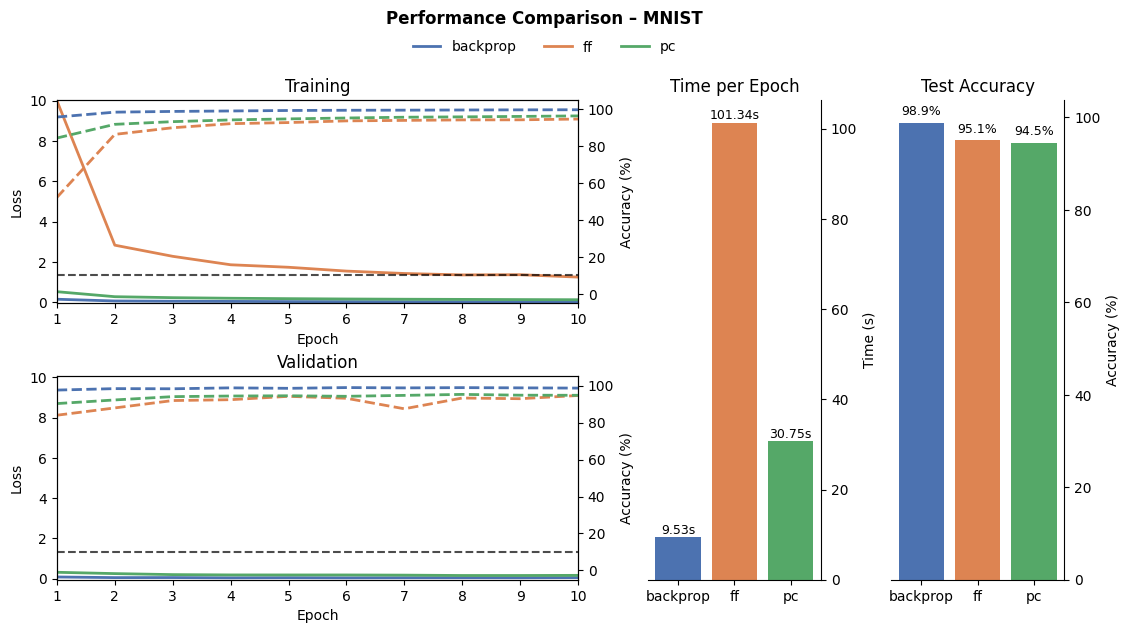

In [37]:
metrics = pd.read_csv("../results/mnist-metrics.csv")
histories = {
    "backprop": pd.read_csv("../results/backprop-history.csv"),
    "ff": pd.read_csv("../results/ff-history.csv"),
    "pc": pd.read_csv("../results/pc-history.csv"),
}

plot_learning_curve_and_performance(
    metrics=metrics,
    histories=histories,
    save_path="../results/training-curves.png",
    chance=100 / n_classes,
)

# TODO: per class accuracy